# **1.   LEXICÓN**



## Enfoque de aprendizaje basado en lexicón

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import requests
import pandas as pd
import io

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Descargamos el lexicón
response = requests.get('https://raw.github.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
nrc = response.text

# Leemos el archivo en un DataFrame
emolex_df = pd.read_csv(io.StringIO(nrc),
                        names=["word", "emotion", "association"],
                        sep=r'\t')

# Convertimos el DataFrame a una forma pivotada
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()

# Quitamos la fila vacía inicial (si existe)
emolex_words.dropna(subset=['word'], inplace=True)

# Reemplazamos "anticipation" y "trust" por "other"
emolex_words['other'] = emolex_words[['anticipation', 'trust']].sum(axis=1)

# Eliminamos las columnas "anticipation" y "trust"
emolex_words.drop(['anticipation', 'trust'], axis=1, inplace=True)


# Visualizamos el DataFrame con los cambios
emolex_words.head()

<ipython-input-2-d7b844053296>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  emolex_df = pd.read_csv(io.StringIO(nrc),


emotion,word,anger,disgust,fear,joy,negative,positive,sadness,surprise,other
1,aback,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,1
3,abandon,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,1,0,1,0,1,0,0
5,abandonment,1,0,1,0,1,0,1,1,0


In [ ]:
# Obtenemos las emociones que constan en el lexicón
emotions = emolex_words.columns.drop('word')
emotions

Index(['anger', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness',
       'surprise', 'other'],
      dtype='object', name='emotion')

### Preprocesamiento de datos

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
carer_test = '/content/drive/MyDrive/CARER/test.txt'

Mounted at /content/drive


In [ ]:
import pandas as pd

# Rutas de los archivos
test_file_path = '/content/drive/MyDrive/CARER/test.txt'
train_file_path = '/content/drive/MyDrive/CARER/train.txt'
valid_file_path = '/content/drive/MyDrive/CARER/valid.txt'

# Leer los archivos de entrenamiento y validación en DataFrames
df_test = pd.read_csv(test_file_path, delimiter=';', header=None, names=['tweet', 'emotion'])
df_train = pd.read_csv(train_file_path, delimiter=';', header=None, names=['tweet', 'emotion'])
df_valid = pd.read_csv(valid_file_path, delimiter=';', header=None, names=['tweet', 'emotion'])

# Guardar los DataFrames como archivos CSV
df_test.to_csv('/content/drive/MyDrive/CARER/test.csv', index=False)
df_train.to_csv('/content/drive/MyDrive/CARER/train.csv', index=False)
df_valid.to_csv('/content/drive/MyDrive/CARER/valid.csv', index=False)



In [ ]:
df_test.head()

,tweet,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


### Cargar datos y entrenar el modelo

In [ ]:
import re
import pandas as pd


from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Definir la función para preprocesar el texto de los tweets
def preprocess_tweet_text(text):
    # Verificar si el valor es una cadena de caracteres
    if isinstance(text, str):
        # Quitar URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # Quitar símbolo de hashtag '#'
        text = re.sub(r'\#','', text)
        # Reemplazar @xxx por user
        text = re.sub(r'\@\w+','user', text)
    return text

# Cargar el archivo CSV
file_path = '/content/drive/MyDrive/CARER/test.csv'

df_test = pd.read_csv(file_path, delimiter=',')

# Aplicar la función de preprocesamiento a la columna 'tweet'
df_test["tweet"] = df_test["tweet"].astype(str).apply(preprocess_tweet_text)

# Mostrar los datos procesados
print(df_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                  tweet  emotion
0     im feeling rather rotten so im not very ambiti...  sadness
1             im updating my blog because i feel shitty  sadness
2     i never make her separate from me because i do...  sadness
3     i left with my bouquet of red and yellow tulip...      joy
4       i was feeling a little vain when i did this one  sadness
...                                                 ...      ...
1995  i just keep feeling like someone is being unki...    anger
1996  im feeling a little cranky negative after this...    anger
1997  i feel that i am useful to my people and that ...      joy
1998  im feeling more comfortable with derby i feel ...      joy
1999  i feel all weird when i have to meet w people ...     fear

[2000 rows x 2 columns]


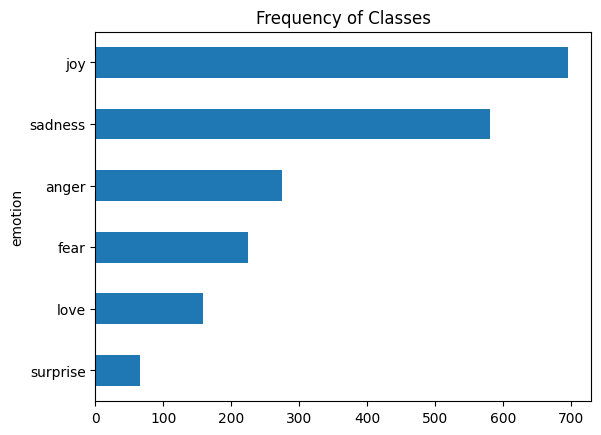

In [ ]:
import matplotlib.pyplot as plt

df_test["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Definir el diccionario de emociones y las emociones disponibles
emolex_dict = {'anger': [], 'joy': [], 'fear': [], 'sadness': [], 'surprise': []}
emotions = emolex_dict.keys()

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def predict_emotion(tweet):
    pos_tagged_text = pos_tag(word_tokenize(tweet))
    word_count = len(pos_tagged_text)
    rows_list = []

    for word, tag in pos_tagged_text:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = lemmatizer.lemmatize(word, wntag) if wntag else word
        emo_score = emolex_words[emolex_words.word == lemma]
        if not emo_score.empty:
            rows_list.append(emo_score)

    if not rows_list:
        return "no emotion"

    df = pd.concat(rows_list)

    for emotion in emotions:
        emolex_dict[emotion] = df[emotion].sum() / word_count if emotion in df else 0

    # Tomar como etiqueta la emoción con el score más alto. Si todos los valores son 0, la etiqueta es "no emotion"
    predicted_emotion = max(emolex_dict, key=emolex_dict.get)
    if all(value == 0 for value in emolex_dict.values()):
        predicted_emotion = "no emotion"

    return predicted_emotion

# Aplicar la función a la columna de tweets y etiquetas
df_test["predicted_emotion"] = df_test["tweet"].apply(predict_emotion)
df_test.head(100)

,tweet,emotion,predicted_emotion
0,im feeling rather rotten so im not very ambiti...,sadness,no emotion
1,im updating my blog because i feel shitty,sadness,no emotion
2,i never make her separate from me because i do...,sadness,sadness
3,i left with my bouquet of red and yellow tulip...,joy,joy
4,i was feeling a little vain when i did this one,sadness,no emotion
...,...,...,...
95,im feeling angry at someone i do something tho...,anger,anger
96,i love neglecting this blog but sometimes i fe...,love,joy
97,i lay in bed feeling as though i were awaiting...,sadness,joy
98,i feel my heart is tortured by what i have done,anger,anger


In [ ]:
from sklearn.metrics import classification_report

# Filtrar 'no emotion' de df_test['predicted_emotion']
filtered_df_test = df_test[df_test['predicted_emotion'] != 'no emotion']

# Generar el informe de clasificación
print(classification_report(filtered_df_test['emotion'], filtered_df_test['predicted_emotion']))



              precision    recall  f1-score   support

       anger       0.25      0.55      0.35       213
        fear       0.32      0.36      0.34       174
         joy       0.57      0.68      0.62       509
        love       0.00      0.00      0.00       125
     sadness       0.63      0.27      0.38       448
    surprise       0.16      0.15      0.15        47

    accuracy                           0.43      1516
   macro avg       0.32      0.34      0.31      1516
weighted avg       0.45      0.43      0.41      1516



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


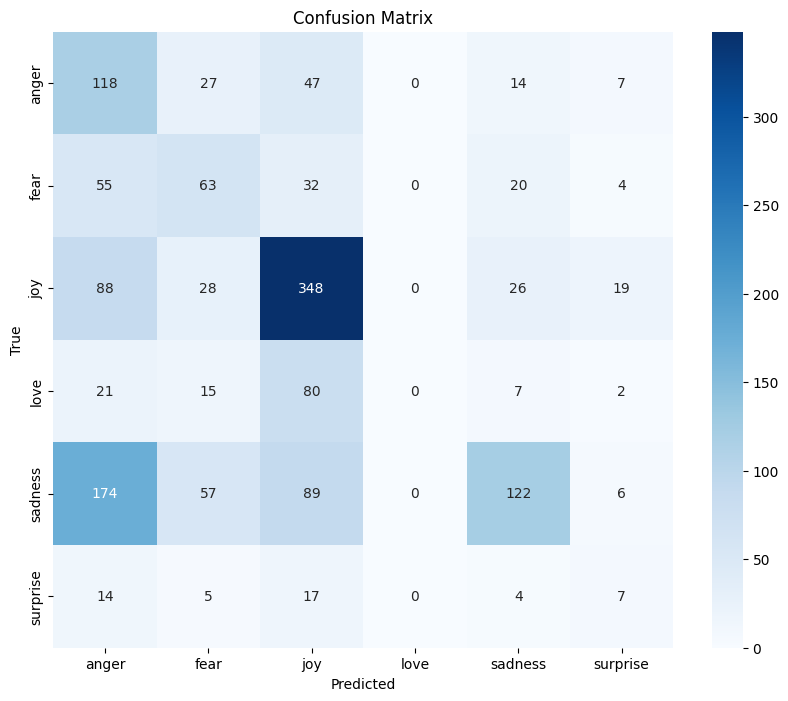

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Calcular la matriz de confusión
cm = confusion_matrix(filtered_df_test['emotion'],filtered_df_test['predicted_emotion'])

# Definir las etiquetas de las clases (emociones)
classes = sorted(filtered_df_test['emotion'].unique())

# Crear una visualización de la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **2.   MACHINE LEARNING**



## Enfoque con Naive Bayes Multinomial, Regresión logística y Ridge Classifier

In [ ]:
import pandas as pd
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')

# Especifica las rutas a los archivos CSV de los conjuntos de datos divididos
train_file = '/content/drive/MyDrive/CARER/train.csv'
validation_file = '/content/drive/MyDrive/CARER/valid.csv'
test_file = '/content/drive/MyDrive/CARER/test.csv'

# Cargar los conjuntos de datos divididos en DataFrames de Pandas
df_train = pd.read_csv(train_file, delimiter=",")
df_validation = pd.read_csv(validation_file, delimiter=",")
df_test = pd.read_csv(test_file, delimiter=",")

Mounted at /content/drive


### Preprocesamiento de los datos y preparación del entorno

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import re
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Definir la función para preprocesar el texto de los tweets
def preprocess_tweet_text(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\#','', text)
        text = re.sub(r'\@\w+','user', text)
    return text

# Especifica las rutas a los archivos CSV de los conjuntos de datos divididos
train_file = '/content/drive/MyDrive/CARER/train.csv'
validation_file = '/content/drive/MyDrive/CARER/valid.csv'
test_file = '/content/drive/MyDrive/CARER/test.csv'

# Aplicar preprocesamiento del texto a las columnas 'tweet'
df_train['tweet'] = df_train['tweet'].apply(preprocess_tweet_text)
df_validation['tweet'] = df_validation['tweet'].apply(preprocess_tweet_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_tweet_text)

# Remover filas con valores NaN en la columna 'tweet'
df_train = df_train.dropna(subset=['tweet'])
df_validation = df_validation.dropna(subset=['tweet'])
df_test = df_test.dropna(subset=['tweet'])


# Definir y ajustar el CountVectorizer en el conjunto de entrenamiento
cv = CountVectorizer()
X_train = cv.fit_transform(df_train['tweet'])
X_valid = cv.transform(df_validation['tweet'])
X_test = cv.transform(df_test['tweet'])

# Obtener las etiquetas de las clases
y_train = df_train['emotion']
y_valid = df_validation['emotion']
y_test = df_test['emotion']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Entrenar y evaluar el modelo Multinomial Naive Bayes

### Definir el modelo, hiperparámetros y visualizar el informe de clasificación

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Definir el clasificador MNB
nb_clf = MultinomialNB()

# Definir los hiperparámetros a ajustar
param_grid_nb = {'alpha': [0.1, 1, 10]}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search_nb = GridSearchCV(nb_clf, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

# Obtener el mejor estimador
best_nb_clf = grid_search_nb.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de validación
y_pred_valid_nb = best_nb_clf.predict(X_valid)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters for MNB:", grid_search_nb.best_params_)

# Calcular la precisión en el conjunto de validación
val_score_nb = accuracy_score(y_valid, y_pred_valid_nb)
print("Validation accuracy (MNB):", val_score_nb)

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_test_nb = best_nb_clf.predict(X_test)

# Calcular la precisión en el conjunto de prueba
test_score_nb = accuracy_score(y_test, y_pred_test_nb)
print("Test accuracy (MNB):", test_score_nb)

# Reporte de clasificación
print("Classification report (MNB):")
print(classification_report(y_test, y_pred_test_nb))

Best hyperparameters for MNB: {'alpha': 0.1}
Validation accuracy (MNB): 0.7845
Test accuracy (MNB): 0.78
Classification report (MNB):
              precision    recall  f1-score   support

       anger       0.77      0.72      0.74       275
        fear       0.73      0.70      0.71       224
         joy       0.81      0.86      0.83       695
        love       0.66      0.57      0.61       159
     sadness       0.81      0.84      0.82       581
    surprise       0.64      0.41      0.50        66

    accuracy                           0.78      2000
   macro avg       0.74      0.68      0.70      2000
weighted avg       0.78      0.78      0.78      2000



### Visualizar la matriz de confusión

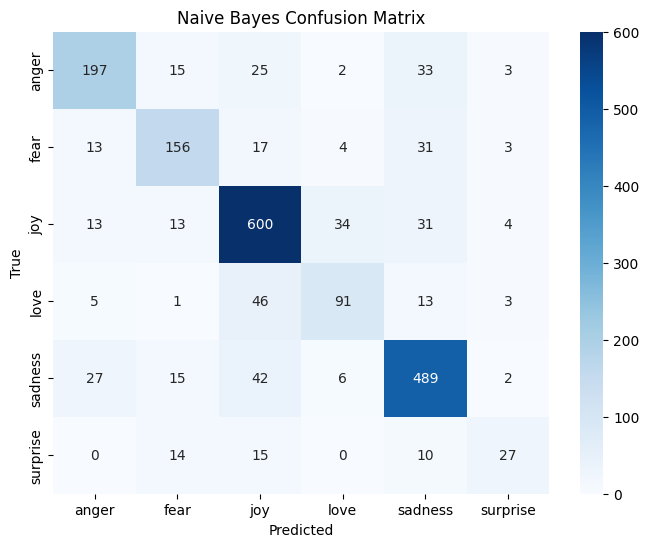

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
conf_matrix_nb = confusion_matrix(y_test, y_pred_test_nb)

# Visualización de la matriz de confusión
labels = sorted(df_test['emotion'].unique())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Entrenar y evaluar el modelo con Regresión Logística

### Definir el modelo y visualizar el informe de clasificación

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid_log_reg = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

# Obtener el mejor estimador
best_log_reg = grid_search_log_reg.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_log_reg = best_log_reg.predict(X_test)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters:", grid_search_log_reg.best_params_)

# Calcular la precisión en el conjunto de validación
val_score_log_reg = grid_search_log_reg.score(X_valid, y_valid)
print("Validation accuracy (Logistic Regression):", val_score_log_reg)

# Ajustar el mejor modelo nuevamente con el hiperparámetro encontrado
best_log_reg = LogisticRegression(C=grid_search_log_reg.best_params_['C'],
                                  solver=grid_search_log_reg.best_params_['solver'],
                                  max_iter=1000)
best_log_reg.fit(X_train, y_train)

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_log_reg = best_log_reg.predict(X_test)

# Calcular la precisión en el conjunto de prueba
test_score_log_reg = best_log_reg.score(X_test, y_test)
print("Test accuracy (Logistic Regression):", test_score_log_reg)

# Reporte de clasificación
print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg))


Best hyperparameters: {'C': 10, 'solver': 'liblinear'}
Validation accuracy (Logistic Regression): 0.898
Test accuracy (Logistic Regression): 0.891
Classification report (Logistic Regression):
              precision    recall  f1-score   support

       anger       0.89      0.88      0.88       275
        fear       0.87      0.86      0.87       224
         joy       0.91      0.93      0.92       695
        love       0.77      0.76      0.76       159
     sadness       0.93      0.93      0.93       581
    surprise       0.74      0.65      0.69        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



### Visualizar la matriz de confusión

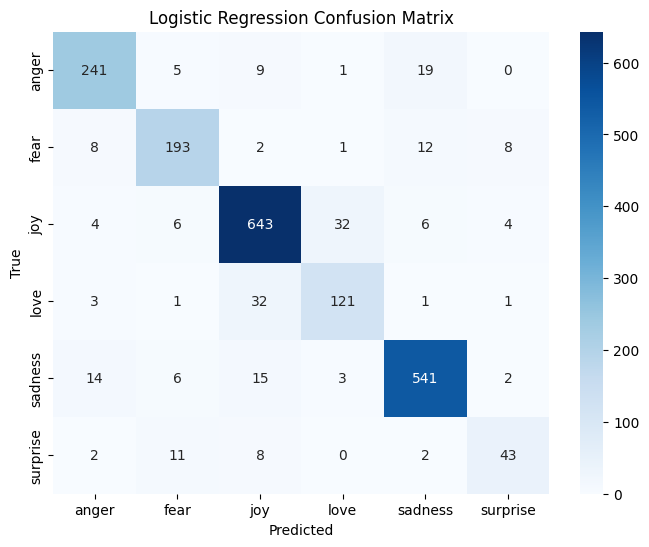

In [ ]:
# Matriz de confusión
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



## Entrenar y evaluar el modelo con el Clasificador Ridge

### Definir el modelo y visualizar el informe de clasificación

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Definir el clasificador Ridge
ridge_clf = RidgeClassifier()

# Definir los hiperparámetros a ajustar
param_grid_ridge = {'alpha': [0.1, 1, 10]}  # alpha es el parámetro de regularización

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(ridge_clf, param_grid_ridge, cv=5, scoring='accuracy')

# Realizar la búsqueda en cuadrícula y entrenar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor estimador
best_ridge_clf = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_ridge = best_ridge_clf.predict(X_test)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters:", grid_search.best_params_)

# Calcular la precisión en el conjunto de prueba
test_score_ridge = accuracy_score(y_test, y_pred_ridge)
print("Test accuracy (Ridge Classifier):", test_score_ridge)

# Validación cruzada para obtener la puntuación de validación
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

# Reporte de clasificación
print("Classification report (Ridge Classifier):")
print(classification_report(y_test, y_pred_ridge))




Best hyperparameters: {'alpha': 10}
Test accuracy (Ridge Classifier): 0.901
Validation accuracy: 0.9055
Classification report (Ridge Classifier):
              precision    recall  f1-score   support

       anger       0.90      0.89      0.89       275
        fear       0.88      0.85      0.86       224
         joy       0.91      0.94      0.93       695
        love       0.83      0.77      0.80       159
     sadness       0.93      0.95      0.94       581
    surprise       0.71      0.62      0.66        66

    accuracy                           0.90      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



### Visualizar la matriz de confusión

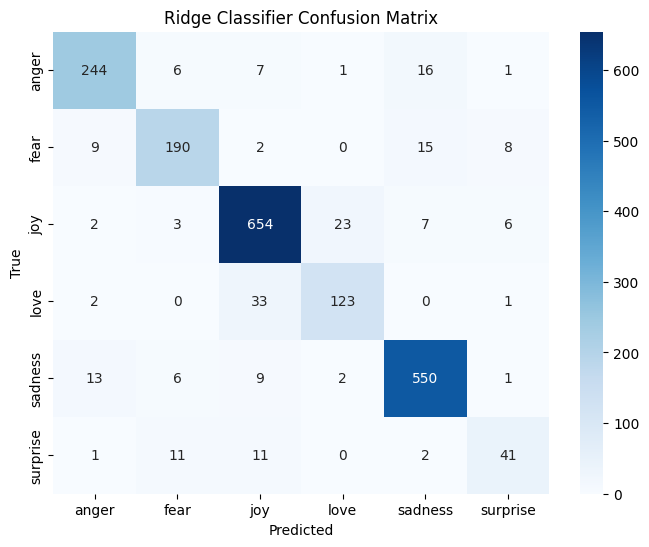

In [ ]:
# Matriz de confusión
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ridge, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Ridge Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Guardar los datos

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Guardar los informes de clasificación individuales
# Multinomial Naive Bayes
clf_report_nb = classification_report(y_test, y_pred_test_nb, zero_division=0, output_dict=True)
df_results_nb = pd.DataFrame(clf_report_nb).transpose()

# Logistic Regression
clf_report_log_reg = classification_report(y_test, y_pred_log_reg, zero_division=0, output_dict=True)
df_results_log_reg = pd.DataFrame(clf_report_log_reg).transpose()

# Ridge Classifier
clf_report_ridge = classification_report(y_test, y_pred_ridge, zero_division=0, output_dict=True)
df_results_ridge = pd.DataFrame(clf_report_ridge).transpose()

# Concatenar los DataFrames de los informes de clasificación
df_classification_reports = pd.concat([df_results_nb, df_results_log_reg, df_results_ridge], axis=1)

# Crear una lista con los nombres de los modelos repetidos para cada grupo de columnas
model_names = ['Naive Bayes'] * len(df_results_nb.columns) + ['Logistic Regression'] * len(df_results_log_reg.columns) + ['Ridge Classifier'] * len(df_results_ridge.columns)

# Asignar los nombres de los modelos a cada columna
df_classification_reports.columns = [f'{model_name} - {col}' for model_name, col in zip(model_names, df_classification_reports.columns)]

# Insertar NaN en las columnas de 'precision' y 'recall' para la fila de 'accuracy'
df_classification_reports.loc['accuracy', df_classification_reports.columns.str.contains('precision')] = float('NaN')
df_classification_reports.loc['accuracy', df_classification_reports.columns.str.contains('recall')] = float('NaN')

# Guardar el DataFrame con los informes de clasificación en un archivo CSV
df_classification_reports.to_csv('/content/drive/MyDrive/CARER/classification_reports_all_models.csv', index=True)

# Imprimir el DataFrame
print(df_classification_reports)

# Crear DataFrames separados para las predicciones de cada modelo y guardarlos
df_nb = df_test[['tweet', 'emotion']].copy()
df_nb['predicted_emotion_nb'] = y_pred_test_nb
df_nb.to_csv('/content/drive/MyDrive/CARER/predictions_naive_bayes.csv', index=False)

df_log_reg = df_test[['tweet', 'emotion']].copy()
df_log_reg['predicted_emotion_log_reg'] = y_pred_log_reg
df_log_reg.to_csv('/content/drive/MyDrive/CARER/predictions_logistic_regression.csv', index=False)

df_ridge = df_test[['tweet', 'emotion']].copy()
df_ridge['predicted_emotion_ridge'] = y_pred_ridge
df_ridge.to_csv('/content/drive/MyDrive/CARER/predictions_ridge.csv', index=False)

print("Todos los resultados y predicciones han sido guardados con éxito.")


              Naive Bayes - precision  Naive Bayes - recall  \
anger                        0.772549              0.716364   
fear                         0.728972              0.696429   
joy                          0.805369              0.863309   
love                         0.664234              0.572327   
sadness                      0.805601              0.841652   
surprise                     0.642857              0.409091   
accuracy                          NaN                   NaN   
macro avg                    0.736597              0.683195   
weighted avg                 0.775784              0.780000   

              Naive Bayes - f1-score  Naive Bayes - support  \
anger                       0.743396                 275.00   
fear                        0.712329                 224.00   
joy                         0.833333                 695.00   
love                        0.614865                 159.00   
sadness                     0.823232                 5

In [ ]:
df_classification_reports

,Naive Bayes - precision,Naive Bayes - recall,Naive Bayes - f1-score,Naive Bayes - support,Logistic Regression - precision,Logistic Regression - recall,Logistic Regression - f1-score,Logistic Regression - support,Ridge Classifier - precision,Ridge Classifier - recall,Ridge Classifier - f1-score,Ridge Classifier - support
anger,0.772549,0.716364,0.743396,275.00,0.886029,0.876364,0.881170,275.000,0.900369,0.887273,0.893773,275.000
fear,0.728972,0.696429,0.712329,224.00,0.869369,0.861607,0.865471,224.000,0.879630,0.848214,0.863636,224.000
joy,0.805369,0.863309,0.833333,695.00,0.906911,0.925180,0.915954,695.000,0.913408,0.941007,0.927002,695.000
love,0.664234,0.572327,0.614865,159.00,0.765823,0.761006,0.763407,159.000,0.825503,0.773585,0.798701,159.000
sadness,0.805601,0.841652,0.823232,581.00,0.931153,0.931153,0.931153,581.000,0.932203,0.946644,0.939368,581.000
surprise,0.642857,0.409091,0.500000,66.00,0.741379,0.651515,0.693548,66.000,0.706897,0.621212,0.661290,66.000
accuracy,NaN,NaN,0.780000,0.78,NaN,NaN,0.891000,0.891,NaN,NaN,0.901000,0.901
macro avg,0.736597,0.683195,0.704526,2000.00,0.850111,0.834471,0.841784,2000.000,0.859668,0.836322,0.847295,2000.000
weighted avg,0.775784,0.780000,0.776112,2000.00,0.890198,0.891000,0.890466,2000.000,0.899489,0.901000,0.899960,2000.000


In [ ]:
import pandas as pd


# Crear un DataFrame con todas las predicciones
df_all_predictions = df_test[['tweet', 'emotion']].copy()
df_all_predictions['predicted_emotion_nb'] = y_pred_test_nb
df_all_predictions['predicted_emotion_log_reg'] = y_pred_log_reg
df_all_predictions['predicted_emotion_ridge'] = y_pred_ridge

# Guardar el DataFrame con todas las predicciones en un archivo CSV
df_all_predictions.to_csv('/content/drive/MyDrive/CARER/carer_predictions_all_models.csv', index=False)

# Imprimir el DataFrame
print(df_all_predictions)

                                                  tweet  emotion  \
0     im feeling rather rotten so im not very ambiti...  sadness   
1             im updating my blog because i feel shitty  sadness   
2     i never make her separate from me because i do...  sadness   
3     i left with my bouquet of red and yellow tulip...      joy   
4       i was feeling a little vain when i did this one  sadness   
...                                                 ...      ...   
1995  i just keep feeling like someone is being unki...    anger   
1996  im feeling a little cranky negative after this...    anger   
1997  i feel that i am useful to my people and that ...      joy   
1998  im feeling more comfortable with derby i feel ...      joy   
1999  i feel all weird when i have to meet w people ...     fear   

     predicted_emotion_nb predicted_emotion_log_reg predicted_emotion_ridge  
0                 sadness                   sadness                 sadness  
1                 sadness  

In [ ]:
import pandas as pd

# Supongamos que tienes tus datos originales y predicciones
original_texts = df_test['tweet'].tolist()  # Textos originales
y_pred_test_nb = best_nb_clf.predict(X_test)  # Predicciones de Naive Bayes
y_pred_log_reg = best_log_reg.predict(X_test)  # Predicciones de Regresión Logística
y_pred_ridge = best_ridge_clf.predict(X_test)  # Predicciones de Clasificador Ridge
y_test = df_test['emotion'].tolist()  # Etiquetas verdaderas

# Crear un DataFrame con las emociones mal predichas y el nombre del LLM
misclassified_rows = []
for text, true_label, pred_nb, pred_log_reg, pred_ridge in zip(original_texts, y_test, y_pred_test_nb, y_pred_log_reg, y_pred_ridge):
    if true_label != pred_nb or true_label != pred_log_reg or true_label != pred_ridge:
        misclassified_rows.append({
            'tweet': text,
            'true_label': true_label,
            'predicted_emotion_nb': pred_nb,
            'predicted_emotion_log_reg': pred_log_reg,
            'predicted_emotion_ridge': pred_ridge
        })

# Convertir la lista a un DataFrame
df_misclassified = pd.DataFrame(misclassified_rows)

# Guardar el DataFrame de emociones mal predichas en un archivo CSV si es necesario
df_misclassified.to_csv('/content/drive/MyDrive/CARER/carer_misclassified_emotions_ML.csv', index=False)

# Mostrar el DataFrame de emociones mal predichas
print("Emociones mal predichas:")
df_misclassified

Emociones mal predichas:


,tweet,true_label,predicted_emotion_nb,predicted_emotion_log_reg,predicted_emotion_ridge
0,i cant walk into a shop anywhere where i do no...,fear,joy,fear,fear
1,i felt anger when at the end of a telephone call,anger,anger,sadness,sadness
2,i don t feel particularly agitated,fear,anger,anger,anger
3,i feel beautifully emotional knowing that thes...,sadness,love,sadness,sadness
4,i pay attention it deepens into a feeling of b...,fear,sadness,sadness,sadness
...,...,...,...,...,...
512,i was feeling playful that day and replied wit...,joy,anger,joy,surprise
513,i have no strong feelings for this book neithe...,anger,anger,love,love
514,im feeling scared and the rage filled im mad a...,fear,anger,fear,fear
515,i have found myself fighting back as he wakes ...,sadness,anger,sadness,sadness


# **3.   DEEP LEARNING**



# Análisis, preprocesamiento y preparación de los datos

In [ ]:
#Cargamos los datasets

from google.colab import drive

drive.mount('/content/drive')
carer_train = '/content/drive/MyDrive/CARER/train.csv'
carer_validation = '/content/drive/MyDrive/CARER/valid.csv'
carer_test = '/content/drive/MyDrive/CARER/test.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [ ]:
import pandas as pd

file_names = [(carer_train, "train"), (carer_validation, "validation"), (carer_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name, delimiter=",")
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,tweet,emotion,split
0,i didnt feel humiliated,sadness,train
1,i can go from feeling so hopeless to so damned...,sadness,train
2,im grabbing a minute to post i feel greedy wrong,anger,train
3,i am ever feeling nostalgic about the fireplac...,love,train
4,i am feeling grouchy,anger,train
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,test
1996,im feeling a little cranky negative after this...,anger,test
1997,i feel that i am useful to my people and that ...,joy,test
1998,im feeling more comfortable with derby i feel ...,joy,test


In [ ]:
df = df[['tweet', 'emotion', 'split']]
df

,tweet,emotion,split
0,i didnt feel humiliated,sadness,train
1,i can go from feeling so hopeless to so damned...,sadness,train
2,im grabbing a minute to post i feel greedy wrong,anger,train
3,i am ever feeling nostalgic about the fireplac...,love,train
4,i am feeling grouchy,anger,train
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,test
1996,im feeling a little cranky negative after this...,anger,test
1997,i feel that i am useful to my people and that ...,joy,test
1998,im feeling more comfortable with derby i feel ...,joy,test


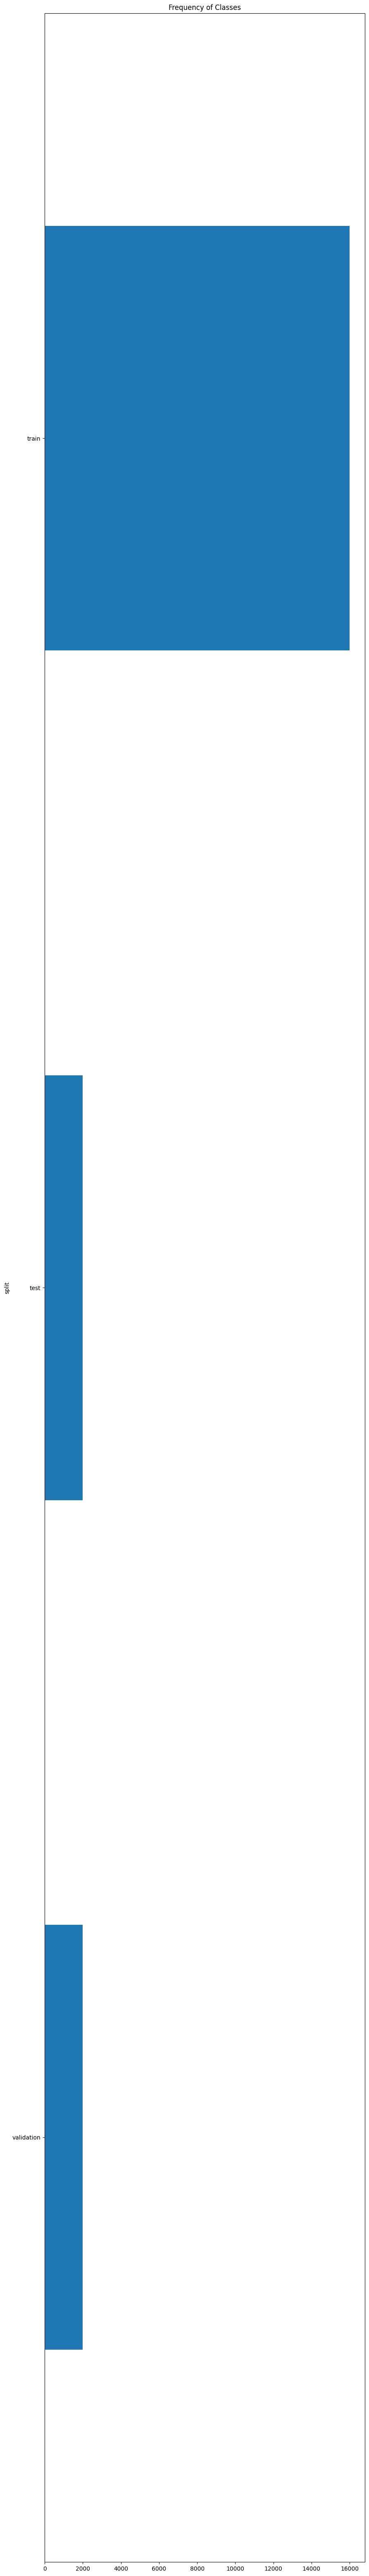

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Preprocesamiento de los tweets
import re
def preprocess_tweet_text(tweet):
    # Quitar urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Quitar símbolo de hashtag '#'
    tweet = re.sub(r'\#','', tweet)
    # Reemplazar @xxx por user
    tweet = re.sub(r'\@\w+','user', tweet)
    return tweet
df['tweet'] = df["tweet"].apply(preprocess_tweet_text)
df

,tweet,emotion,split
0,i didnt feel humiliated,sadness,train
1,i can go from feeling so hopeless to so damned...,sadness,train
2,im grabbing a minute to post i feel greedy wrong,anger,train
3,i am ever feeling nostalgic about the fireplac...,love,train
4,i am feeling grouchy,anger,train
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,test
1996,im feeling a little cranky negative after this...,anger,test
1997,i feel that i am useful to my people and that ...,joy,test
1998,im feeling more comfortable with derby i feel ...,joy,test


Vamos a dividir nuevamente el dataframe en tres, uno por split.

In [ ]:
df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'validation']
df_test = df[df['split'] == 'test']

Debido a la naturaleza poco equilibrada de los datasets en cuanto al número de instancias por clase, vamos a aplicar lo que se conoce como *data augmentation*. Data augmentation es un proceso de generación de nuevos datos a partir de datos existentes, con el objetivo de mejorar el rendimiento de un modelo de aprendizaje automático. El proceso se lleva a cabo modificando ligeramente los datos existentes, utilizando técnicas específicas para cada tipo de dato (por ejemplo, rotando imágenes en el caso de imágenes, o modificando el orden de las palabras en el caso de texto). Al aumentar el tamaño del conjunto de datos de entrenamiento, se puede esperar que el modelo generalice mejor a datos no vistos durante el entrenamiento.

Para hacer data augmentation en categorías infrarepresentadas en el dataset de tweets, se pueden utilizar varias técnicas. Una opción es generar nuevos tweets a partir de los existentes, por ejemplo, cambiando palabras por sinónimos, cambiando el orden de las palabras o añadiendo palabras adicionales. También se pueden utilizar técnicas de traducción para obtener nuevos tweets en otro idioma y luego traducirlos al idioma original. Otro enfoque podría ser utilizar técnicas de aprendizaje automático para generar nuevos tweets a partir de un modelo entrenado en el dataset de tweets existente.



## Visualización de la frecuencia de clases

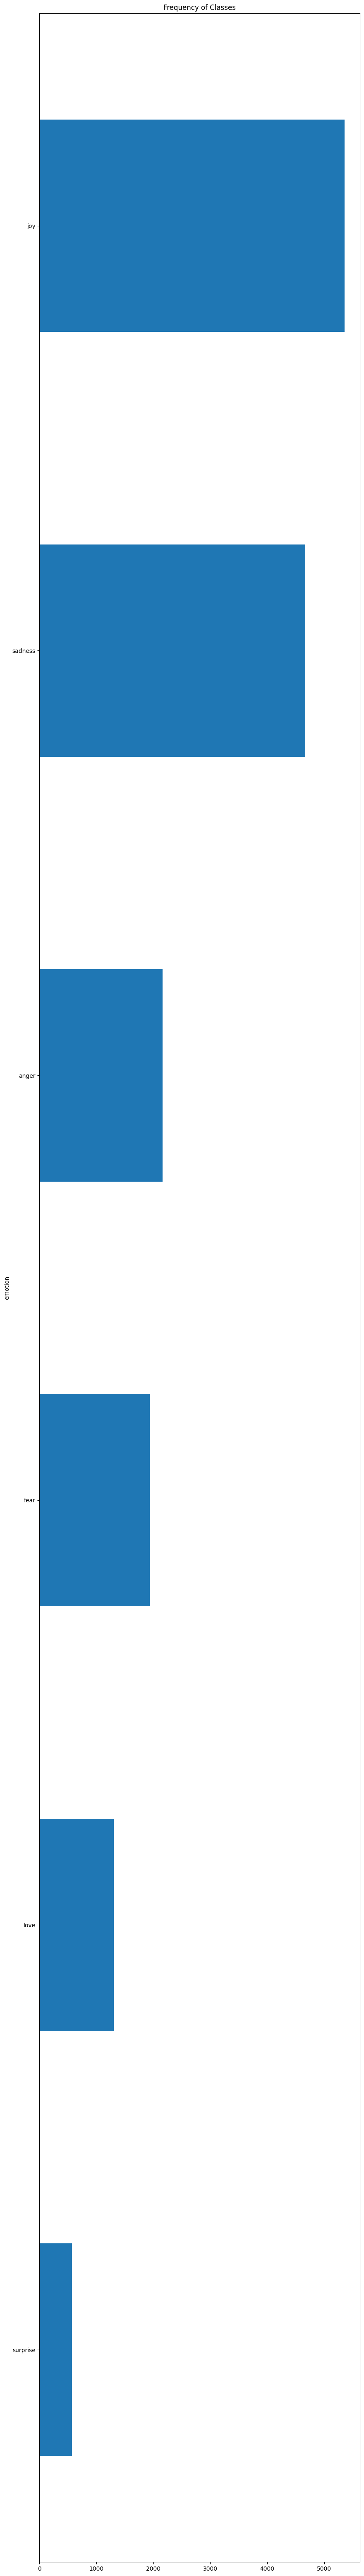

In [ ]:
# Distribucion de instancias por clases (i.e. emociones): dataset equilibrado

df_train["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Aleatorizamos los datasets.

In [ ]:
# Fijar semilla para reproducibilidad
import random
import numpy as np
import tensorflow as tf
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [ ]:
import random
random.seed(0)

df_train = df_train.sample(frac=1, random_state=RANDOM_SEED)
df_valid = df_valid.sample(frac=1, random_state=RANDOM_SEED)
df_test = df_test.sample(frac=1, random_state=RANDOM_SEED)

df_train

,tweet,emotion,split
8756,ive made it through a week i just feel beaten ...,sadness,train
4660,i feel this strategy is worthwhile,joy,train
6095,i feel so worthless and weak what does he have...,sadness,train
304,i feel clever nov,joy,train
8241,im moved in ive been feeling kind of gloomy,sadness,train
...,...,...,...
13418,i love this because to me it should leave the ...,fear,train
5390,i feel is very delicate,love,train
860,i was starting to feel a little stressed,sadness,train
15795,i feel stressed tired worn out out of shape or...,sadness,train


In [ ]:
X_train = df_train['tweet']
X_valid = df_valid['tweet']
X_test = df_test['tweet']

y_train = df_train['emotion']
y_valid = df_valid['emotion']
y_test = df_test['emotion']

X_train

8756     ive made it through a week i just feel beaten ...
4660                    i feel this strategy is worthwhile
6095     i feel so worthless and weak what does he have...
304                                      i feel clever nov
8241           im moved in ive been feeling kind of gloomy
                               ...                        
13418    i love this because to me it should leave the ...
5390                               i feel is very delicate
860               i was starting to feel a little stressed
15795    i feel stressed tired worn out out of shape or...
7270     i feel that someone is being rude or has wrong...
Name: tweet, Length: 16000, dtype: object

Vamos a realizar lo que se conoce como one-hot encoding, una técnica de preprocesamiento de datos que se utiliza a menudo en la creación de modelos de aprendizaje automático. Se utiliza para convertir variables categóricas, es decir, variables que solo pueden tomar un número limitado de valores discretos, como cadenas de texto, en formato numérico.

En este caso, se utiliza la clase LabelBinarizer de scikit-learn para realizar one-hot encoding en las etiquetas de entrenamiento, validación y prueba. Luego, se utilizan los métodos fit_transform y transform para ajustar el encoder a los datos de entrenamiento y luego transformar los datos de validación y prueba, respectivamente.

El método fit_transform ajusta el encoder a los datos de entrenamiento y luego realiza la transformación. El método transform, por otro lado, solo realiza la transformación utilizando el encoder ya ajustado.

Una vez que se han realizado los one-hot encoding, cada etiqueta se representa como un vector de ceros y unos, donde solo una posición del vector tiene un valor de uno y el resto tiene un valor de cero. Por ejemplo, si tenemos tres categorías, A, B y C, entonces la etiqueta A se representaría como [1, 0, 0], la etiqueta B como [0, 1, 0] y la etiqueta C como [0, 0, 1].

Una vez que se han realizado los one-hot encoding, se puede utilizar el conjunto de datos transformado para entrenar un modelo de redes neuronales con Keras.


In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

# Entrenamiento de redes neuronales

In [ ]:
!pip install keras
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 791.6 kB/s eta 0:00:00


En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid= tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)
X_train

[[72, 131, 12, 137, 6, 200, 1, 31, 2, 565, 141],
 [1, 2, 22, 2474, 21, 746],
 [1,
  2,
  14,
  628,
  3,
  1332,
  53,
  258,
  65,
  20,
  4,
  118,
  7,
  89,
  53,
  1,
  66,
  4,
  163,
  49],
 [1, 2, 653, 4156],
 [16, 1430, 11, 72, 46, 8, 167, 9, 581],
 [1,
  1010,
  50,
  4,
  2,
  5,
  40,
  465,
  114,
  186,
  1,
  19,
  482,
  36,
  6,
  5,
  7399,
  129,
  2735,
  14,
  12,
  269,
  150,
  3,
  1148,
  14,
  1,
  91,
  1612,
  1,
  19,
  482,
  161,
  59,
  63],
 [1, 2, 437, 93],
 [1,
  2,
  13,
  6,
  609,
  4157,
  48,
  129,
  1176,
  11,
  18,
  79,
  43,
  148,
  152,
  1,
  40,
  130,
  301,
  85,
  318,
  124,
  7400,
  49,
  4,
  5,
  1770,
  32,
  2118],
 [1,
  2,
  13,
  1,
  406,
  10,
  520,
  85,
  169,
  173,
  1,
  19,
  767,
  6,
  7401,
  293,
  1771,
  3,
  1,
  314,
  1,
  23,
  767,
  6,
  7402,
  1771],
 [1,
  2,
  5,
  285,
  582,
  2736,
  4,
  208,
  41,
  4,
  1149,
  24,
  132,
  196,
  1333,
  14,
  11,
  747,
  4,
  7403,
  5,
  1064,
  134,
  81,

In [ ]:
# Inicializar la longitud máxima a 0
max_length = 0

# Recorrer cada elemento en X_train
for x in X_train:
    # Calcular la longitud del elemento actual
    length = len(x)

    # Actualizar la longitud máxima si la longitud actual es mayor
    if length > max_length:
        max_length = length

# Imprimir la longitud máxima encontrada
print("La longitud máxima es:", max_length)


La longitud máxima es: 66


In [ ]:
for x in X_train:
  if len(x)>66:
    print(len(x))


Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 60. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 60.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 60. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 66

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train

array([[ 72, 131,  12, ...,   0,   0,   0],
       [  1,   2,  22, ...,   0,   0,   0],
       [  1,   2,  14, ...,   0,   0,   0],
       ...,
       [  1,  19, 317, ...,   0,   0,   0],
       [  1,   2, 235, ...,   0,   0,   0],
       [  1,   2,   7, ...,   0,   0,   0]], dtype=int32)

In [ ]:
tokenizer.word_index

{'i': 1,
 'feel': 2,
 'and': 3,
 'to': 4,
 'the': 5,
 'a': 6,
 'that': 7,
 'feeling': 8,
 'of': 9,
 'my': 10,
 'in': 11,
 'it': 12,
 'like': 13,
 'so': 14,
 'for': 15,
 'im': 16,
 'me': 17,
 'but': 18,
 'was': 19,
 'have': 20,
 'is': 21,
 'this': 22,
 'am': 23,
 'with': 24,
 'not': 25,
 'about': 26,
 'be': 27,
 'as': 28,
 'on': 29,
 'you': 30,
 'just': 31,
 'at': 32,
 'when': 33,
 'or': 34,
 'all': 35,
 'because': 36,
 'more': 37,
 'do': 38,
 'can': 39,
 'really': 40,
 'up': 41,
 't': 42,
 'are': 43,
 'by': 44,
 'very': 45,
 'been': 46,
 'know': 47,
 'if': 48,
 'out': 49,
 'myself': 50,
 'time': 51,
 'how': 52,
 'what': 53,
 'get': 54,
 'little': 55,
 'had': 56,
 'now': 57,
 'will': 58,
 'from': 59,
 'being': 60,
 'they': 61,
 'people': 62,
 'them': 63,
 'would': 64,
 'he': 65,
 'want': 66,
 'her': 67,
 'some': 68,
 'think': 69,
 'one': 70,
 'still': 71,
 'ive': 72,
 'him': 73,
 'even': 74,
 'who': 75,
 'an': 76,
 'life': 77,
 'its': 78,
 'there': 79,
 'make': 80,
 'we': 81,
 'bit': 82

## Red neuronal de memoria a largo y corto plazo (LSTM)

La red LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente especialmente adecuada para procesar secuencias de datos.

La capa Embedding se encarga de convertir los textos en secuencias de enteros, donde cada entero representa una palabra en el vocabulario del modelo. Esta capa también especifica la dimensión del espacio vectorial en el que se representarán cada una de las palabras. La capa LSTM procesa esta secuencia de enteros y la capa Dense final realiza la clasificación.

In [ ]:
from keras.layers import LSTM

model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(LSTM(128))
model.add(Dense(len(encoder.classes_), activation='softmax'))

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.4 MB/s eta 0:00:00


La segunda línea de código se utiliza para compilar el modelo de redes neuronales definido previamente. Esto es necesario antes de poder entrenar el modelo o hacer predicciones con él.

La función compile toma tres argumentos:

    optimizer: es el optimizador que se utilizará para entrenar el modelo. El optimizador Adam es una buena opción por defecto para muchos problemas.
    loss: es la función de pérdida que se utilizará para medir el error del modelo durante el entrenamiento. La función de pérdida categorical_crossentropy se utiliza a menudo cuando se tienen varias clases y se utiliza la activación softmax en la capa de salida.
    metrics: es una lista con las métricas que se utilizarán para evaluar el modelo durante el entrenamiento y la validación. Normalmente, se utiliza la precisión (acc).

Vamos a utilizar como métrica el macro-F1. La métrica F1Score es una medida de rendimiento para problemas de clasificación y se basa en el equilibrio entre precisión y recall. Se puede calcular para cada clase por separado o para todas las clases juntas de forma promediada, como se está haciendo aquí con el parámetro "average='macro'".

La tercera línea de código se utiliza para imprimir un resumen del modelo. Esto incluye información sobre el número de capas, los tamaños de las capas y el número de parámetros entrenables del modelo. Esta información puede ser útil para depurar el modelo o para verificar que se ha definido correctamente.

In [ ]:
num_classes = len(encoder.classes_)
num_classes

6

In [ ]:
import tensorflow_addons as tfa
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=6, average='macro')])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 300)           4563000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 4783422 (18.25 MB)
Trainable params: 4783422 (18.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


El resumen del modelo muestra la estructura de la red LSTM. Se puede ver que la capa Embedding tiene una salida de forma (None, 60, 300), lo que significa que para cada ejemplo de entrada, se generará una secuencia de 60 vectores de 300 dimensiones. La capa LSTM tiene una salida de forma (None, 128), lo que significa que para cada ejemplo de entrada, se generará un vector de 128 dimensiones. Por último, la capa Dense tiene una salida de forma (None, 8), lo que significa que para cada ejemplo de entrada, se generará un vector de 8 elementos que corresponden a las 8 clases posibles.

La función EarlyStopping de Keras se utiliza para detener el entrenamiento de un modelo cuando ya no se está mejorando en un conjunto de validación. Esto se hace para evitar el overfitting, es decir, que el modelo se ajuste demasiado a los datos de entrenamiento y tenga un rendimiento peor en los datos de validación o de prueba.

Los parámetros mode y restore_best_weights se utilizan para controlar el comportamiento del callback. El parámetro mode especifica qué medida se va a utilizar para determinar si el modelo está mejorando o no. Los valores válidos son 'auto', 'min' y 'max', y se refieren a si se quiere minimizar o maximizar la medida de pérdida o de metrica especificada en el parámetro monitor. Por ejemplo, si se está entrenando un modelo para clasificación y se quiere minimizar la pérdida categórica cruzada, se puede usar mode='min'.

El parámetro restore_best_weights indica si se quiere guardar el peso del modelo que obtuvo el mejor valor en el conjunto de validación y restaurarlo una vez que se detiene el entrenamiento. Si se establece en True, cuando se detiene el entrenamiento se restaurará el peso del modelo que obtuvo el mejor valor en el conjunto de validación. Si se establece en False, el modelo seguirá utilizando los pesos del último epoch de entrenamiento.

El parámetro "patience" se refiere al número de épocas que se deben esperar antes de detener el entrenamiento si no se observa una mejora en el valor de la métrica de evaluación. Por ejemplo, si se establece patience=2, entonces el entrenamiento se detendrá si no se observa una mejora en la métrica de evaluación durante 2 épocas consecutivas.

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=5)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento. Esta función toma varios argumentos:

    X_train: es una matriz de tamaño (num_ejemplos, longitud_secuencia) con los ejemplos de entrenamiento.
    y_train: es una matriz de tamaño (num_ejemplos, num_clases) con las etiquetas de clase correspondientes a los ejemplos de entrenamiento.
    batch_size: es el tamaño del batch de ejemplos que se utilizará para entrenar el modelo. El tamaño del batch influye en la velocidad de entrenamiento y en la precisión del modelo.
    epochs: es el número de veces que se iterará sobre los datos de entrenamiento.
    verbose: especifica cuánto detalle se muestra mientras se entrena el modelo. Si se establece en 1, se muestran las barras de progreso y una línea de resumen por cada epoch. Si se establece en 0, no se muestra ningún detalle.
    validation_data: es una tupla con los datos de validación y las etiquetas de clase correspondientes. Estos datos se utilizan para evaluar el modelo después de cada epoch y para detener el entrenamiento si no mejora.

La función fit devuelve un objeto history con información sobre el entrenamiento del modelo, como las pérdidas y las métricas de entrenamiento y validación en cada epoch. Esta información puede ser útil para evaluar el rendimiento del modelo y para ajustar sus hiperparámetros.

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 96s 711ms/step - loss: 1.5847 - f1_score: 0.1228 - val_loss: 1.5822 - val_f1_score: 0.0868
Epoch 2/20
125/125 [==============================] - 54s 429ms/step - loss: 1.5787 - f1_score: 0.1063 - val_loss: 1.5815 - val_f1_score: 0.0868
Epoch 3/20
125/125 [==============================] - 50s 400ms/step - loss: 1.5771 - f1_score: 0.0919 - val_loss: 1.5865 - val_f1_score: 0.0868
Epoch 4/20
125/125 [==============================] - 80s 639ms/step - loss: 1.5795 - f1_score: 0.1079 - val_loss: 1.5837 - val_f1_score: 0.0868
Epoch 5/20
125/125 [==============================] - 59s 470ms/step - loss: 1.5768 - f1_score: 0.0837 - val_loss: 1.5834 - val_f1_score: 0.0868
Epoch 6/20
125/125 [==============================] - 51s 406ms/step - loss: 1.5766 - f1_score: 0.0954 - val_loss: 1.5817 - val_f1_score: 0.0868
Epoch 7/20
125/125 [==============================] - 50s 398ms/step - loss: 1.5769 - f1_score: 0.0840 - val_loss: 1.5810 - val_f1

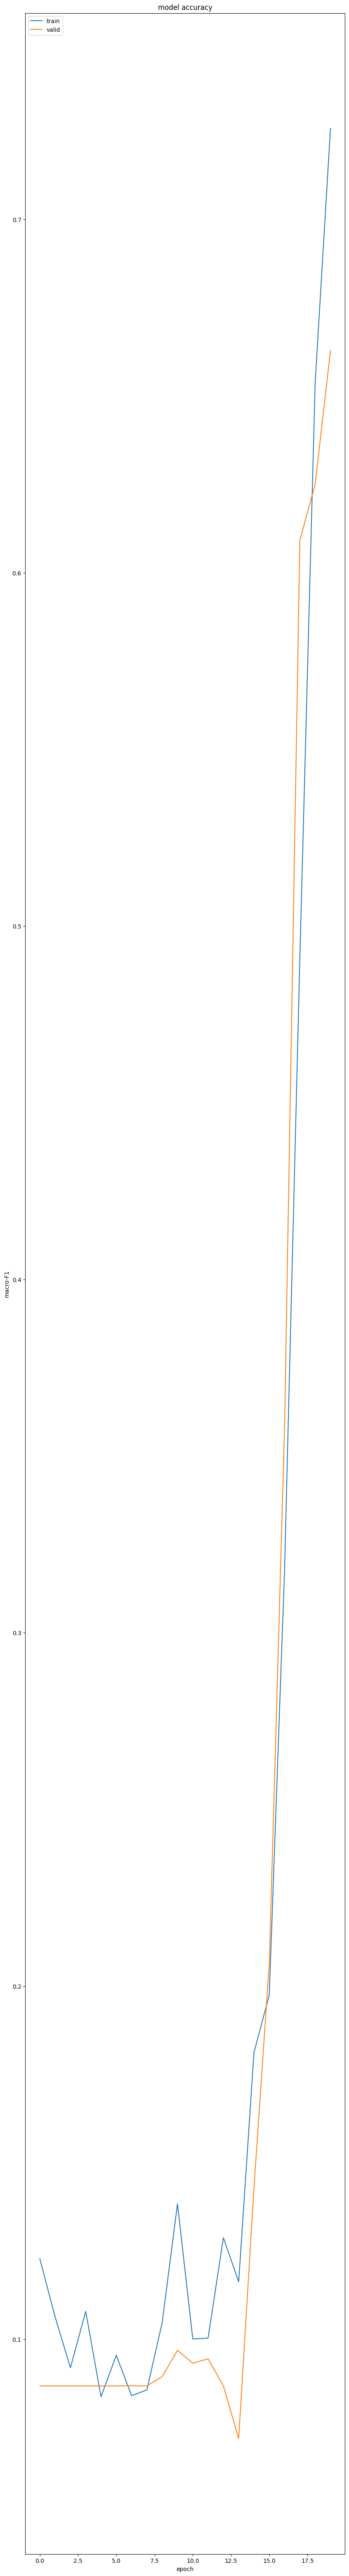

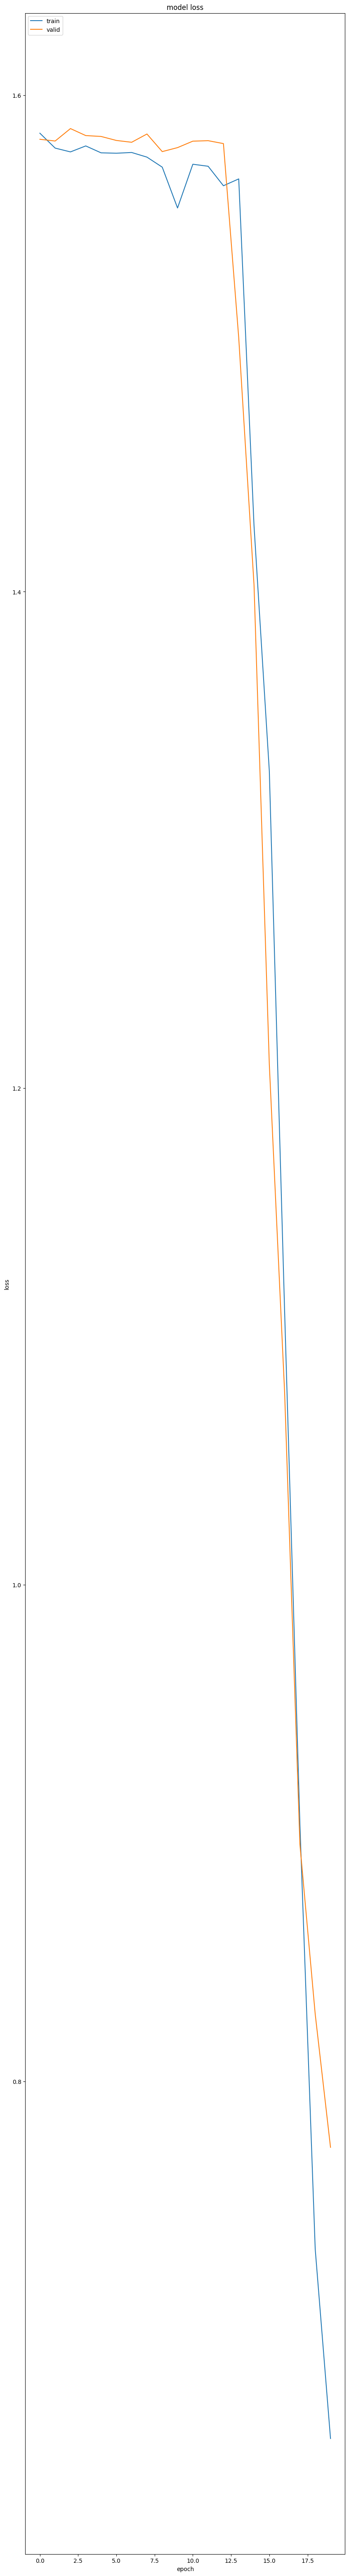

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

La función evaluate de Keras se utiliza para evaluar un modelo en datos de test. Esta función toma tres argumentos:

    X_test: es una matriz de tamaño (num_ejemplos, longitud_secuencia) con los ejemplos de test.
    y_test: es una matriz de tamaño (num_ejemplos, num_clases) con las etiquetas de clase correspondientes a los ejemplos de test.
    verbose: especifica cuánto detalle se muestra mientras se evalúa el modelo. Si se establece en 1, se muestra una barra de progreso y una línea de resumen al final. Si se establece en 0, no se muestra ningún detalle.

La función evaluate devuelve una lista con dos elementos: la pérdida y la métrica de evaluación del modelo en los datos de test. En este caso, la métrica de evaluación es el macro-F1.

La variable score tendrá una lista con la pérdida y el macro-F1 del modelo aplicado al dataset de evaluación. Esta información puede ser útil para evaluar el rendimiento del modelo y compararlo con otros modelos.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 6s 92ms/step - loss: 0.8012 - f1_score: 0.6276


In [ ]:
print("Test Score:", score[0])
print("Test Macro-F1:", score[1])

Test Score: 0.8011576533317566
Test Macro-F1: 0.6275896430015564


La primera línea de código importa la función classification_report de scikit-learn, que se utiliza para generar un informe de clasificación a partir de las etiquetas de clase de verdad y de las predicciones del modelo.

La segunda línea importa la librería numpy.

Luego, se utiliza la función predict del modelo para generar predicciones en el test dataset. Las predicciones son una matriz de tamaño (num_ejemplos, num_clases) con las probabilidades de pertenencia a cada clase.

A continuación, se convierten las predicciones en etiquetas de clase utilizando la función argmax de numpy. La función argmax devuelve el índice del elemento máximo en cada fila de la matriz. Al especificar axis=1, se aplica la función a cada fila en lugar de a cada columna.

Luego, se convierten las etiquetas de clase del conjunto de evaluación en etiquetas de clase utilizando la función argmax de la misma manera.

Por último, se utiliza la función classification_report de scikit-learn para generar un informe de clasificación a partir de las etiquetas de clase del conjunto de test y de las predicciones del modelo.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

63/63 [==============================] - 9s 126ms/step
              precision    recall  f1-score   support

       anger       0.95      0.87      0.91       275
        fear       0.82      0.77      0.79       224
         joy       0.51      0.90      0.65       695
        love       0.71      0.80      0.75       159
     sadness       0.44      0.02      0.04       581
    surprise       0.51      0.79      0.62        66

    accuracy                           0.61      2000
   macro avg       0.66      0.69      0.63      2000
weighted avg       0.60      0.61      0.53      2000



In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_LSTM'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_LSTM']]

# Mostrar los ejemplos erróneos
errores[['tweet', 'emotion', 'prediction_LSTM']]

63/63 [==============================] - 5s 80ms/step


,tweet,emotion,prediction_LSTM
1860,i feel so dirty but after spending a day at th...,sadness,love
353,i could feel his breath on me and smell the sw...,joy,love
905,i have felt the need to write out my sometimes...,anger,surprise
1289,at a party i met a girl who drew me to her,anger,joy
56,i had every intention of doing more gardening ...,sadness,joy
...,...,...,...
1482,i feel that they ignored the systemic nature o...,sadness,joy
1238,i feel bad knocking show down this far but i d...,sadness,joy
466,i feel his hand on me to stay faithful,love,joy
860,i felt so bad for the bad grade and feeling li...,sadness,joy


### LSTM con Dropout

Una forma de crear una LSTM más compleja es añadiendo más capas LSTM a la red. También podemos añadir una capa de Dropout para evitar el sobreajuste, y probar diferentes tamaños de ventana y diferentes tasas de Dropout. Además, podemos probar diferentes optimizadores y valores de aprendizaje inicial. Con esta red LSTM se han añadido dos capas LSTM y dos capas de dropout para evitar el sobreajuste. Además, se ha establecido la opción return_sequences=True en la primera capa LSTM para que devuelva las secuencias de salida en lugar de solo la última salida para poder aplicar la capa de dropout a todas las salidas de la primera capa LSTM.

In [ ]:
from keras.layers import LSTM, Dropout

model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
output_dim=300,
input_length=maxlen))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=6, average='macro')])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 66, 300)           4563000   
                                                                 
 lstm_1 (LSTM)               (None, 66, 128)           219648    
                                                                 
 dropout (Dropout)           (None, 66, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4915006 (18.75 MB)
Trainable params: 491

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 113s 815ms/step - loss: 1.5981 - f1_score: 0.1253 - val_loss: 1.5818 - val_f1_score: 0.0868
Epoch 2/20
125/125 [==============================] - 85s 678ms/step - loss: 1.5866 - f1_score: 0.1173 - val_loss: 1.5808 - val_f1_score: 0.0868
Epoch 3/20
125/125 [==============================] - 81s 649ms/step - loss: 1.5837 - f1_score: 0.1117 - val_loss: 1.5848 - val_f1_score: 0.0868
Epoch 4/20
125/125 [==============================] - 99s 788ms/step - loss: 1.5812 - f1_score: 0.1202 - val_loss: 1.5833 - val_f1_score: 0.0867
Epoch 5/20
125/125 [==============================] - 84s 670ms/step - loss: 1.5618 - f1_score: 0.1443 - val_loss: 1.5829 - val_f1_score: 0.0868
Epoch 6/20
125/125 [==============================] - 82s 659ms/step - loss: 1.4779 - f1_score: 0.2082 - val_loss: 1.3987 - val_f1_score: 0.1903
Epoch 7/20
125/125 [==============================] - 82s 659ms/step - loss: 1.2426 - f1_score: 0.2695 - val_loss: 1.1896 - val_f

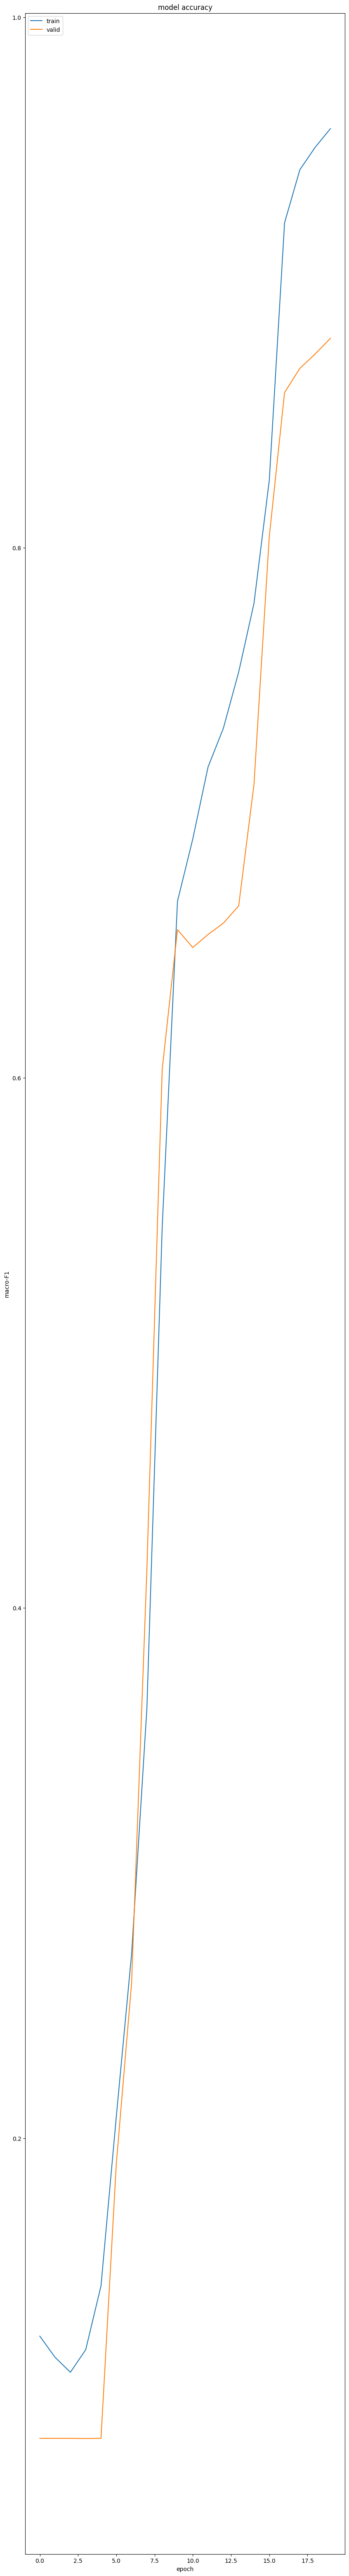

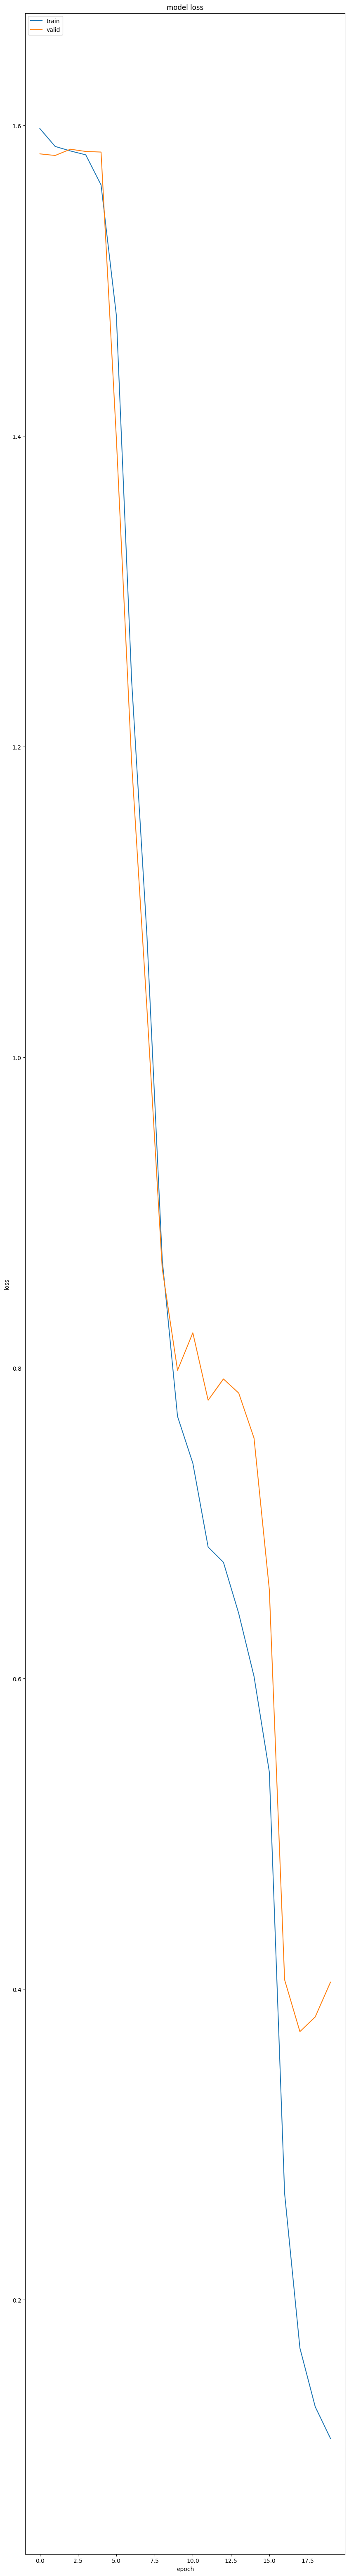

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 7s 111ms/step - loss: 0.4682 - f1_score: 0.8326


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

63/63 [==============================] - 7s 90ms/step
              precision    recall  f1-score   support

       anger       0.87      0.87      0.87       275
        fear       0.86      0.84      0.85       224
         joy       0.90      0.91      0.90       695
        love       0.73      0.81      0.77       159
     sadness       0.95      0.91      0.93       581
    surprise       0.64      0.73      0.68        66

    accuracy                           0.88      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_LSTM_Dropout'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_LSTM_Dropout']]

# Mostrar los ejemplos erróneos
errores[['tweet', 'emotion', 'prediction_LSTM_Dropout']]

63/63 [==============================] - 5s 78ms/step


,tweet,emotion,prediction_LSTM_Dropout
353,i could feel his breath on me and smell the sw...,joy,love
905,i have felt the need to write out my sometimes...,anger,fear
1664,im afraid to call the guy from yesterday becau...,sadness,fear
792,i dont know how to deal with this i feel like ...,fear,anger
251,i hope everyone can help with charity work wit...,sadness,joy
...,...,...,...
1154,i feel that passionate about,joy,love
1184,i feel agitated a lot im straddling articulacy...,anger,fear
343,is hand started fondling his aching cock throu...,joy,sadness
1123,i feel like the writer wants me to think so an...,love,anger


## Red neuronal convolutiva (CNN)

Vamos a utilizar ahora una red neuronal convolutiva (CNN, por sus siglas en inglés), un tipo especial de red neuronal que se utiliza a menudo para procesar datos con una estructura espacial, como imágenes. Una CNN tiene capas de "convolución" que realizan operaciones de filtrado en la entrada para extraer características específicas.

Estas líneas de código implementan un modelo de CNN para procesar texto. La primera capa es una capa de embeddings, que se encarga de convertir cada palabra del texto en un vector de embeddings. Esta capa es seguida por una capa de convolución 1D, que realiza operaciones de filtrado en las secuencias de embeddings para extraer características específicas. La capa de convolución tiene 128 filtros de tamaño 5, y utiliza la función de activación ReLU para aplicar una no-linealidad.

Después de la capa de convolución, se añade una capa de pooling global, que se encarga de reducir la dimensionalidad de las características extraídas por la capa de convolución. En este caso se utiliza pooling global, que se aplica a todas las secuencias de la salida de la capa de convolución y devuelve el máximo valor de cada uno de los filtros.

Por último, se añade una capa densa final con la misma cantidad de unidades que clases de salida y con la función de activación softmax. La función softmax devuelve una distribución de probabilidad sobre las clases de salida, lo que permite interpretar la salida de la red como la probabilidad de que pertenezca a cada clase.

In [ ]:
from keras.layers import Conv1D
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=6, average='macro')])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 66, 300)           4563000   
                                                                 
 conv1d (Conv1D)             (None, 62, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4755902 (18.14 MB)
Trainable params: 4755902 (18.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 40s 312ms/step - loss: 1.1496 - f1_score: 0.3991 - val_loss: 0.3107 - val_f1_score: 0.8647
Epoch 2/20
125/125 [==============================] - 37s 295ms/step - loss: 0.1761 - f1_score: 0.8992 - val_loss: 0.1631 - val_f1_score: 0.9018
Epoch 3/20
125/125 [==============================] - 39s 316ms/step - loss: 0.0890 - f1_score: 0.9460 - val_loss: 0.1617 - val_f1_score: 0.8996
Epoch 4/20
125/125 [==============================] - 36s 291ms/step - loss: 0.0539 - f1_score: 0.9731 - val_loss: 0.1697 - val_f1_score: 0.9037
Epoch 5/20
125/125 [==============================] - 41s 326ms/step - loss: 0.0328 - f1_score: 0.9849 - val_loss: 0.1796 - val_f1_score: 0.9046
Epoch 6/20
125/125 [==============================] - 41s 327ms/step - loss: 0.0217 - f1_score: 0.9896 - val_loss: 0.1953 - val_f1_score: 0.9004
Epoch 7/20
125/125 [==============================] - 66s 528ms/step - loss: 0.0158 - f1_score: 0.9928 - val_loss: 0.1989 - val_f1

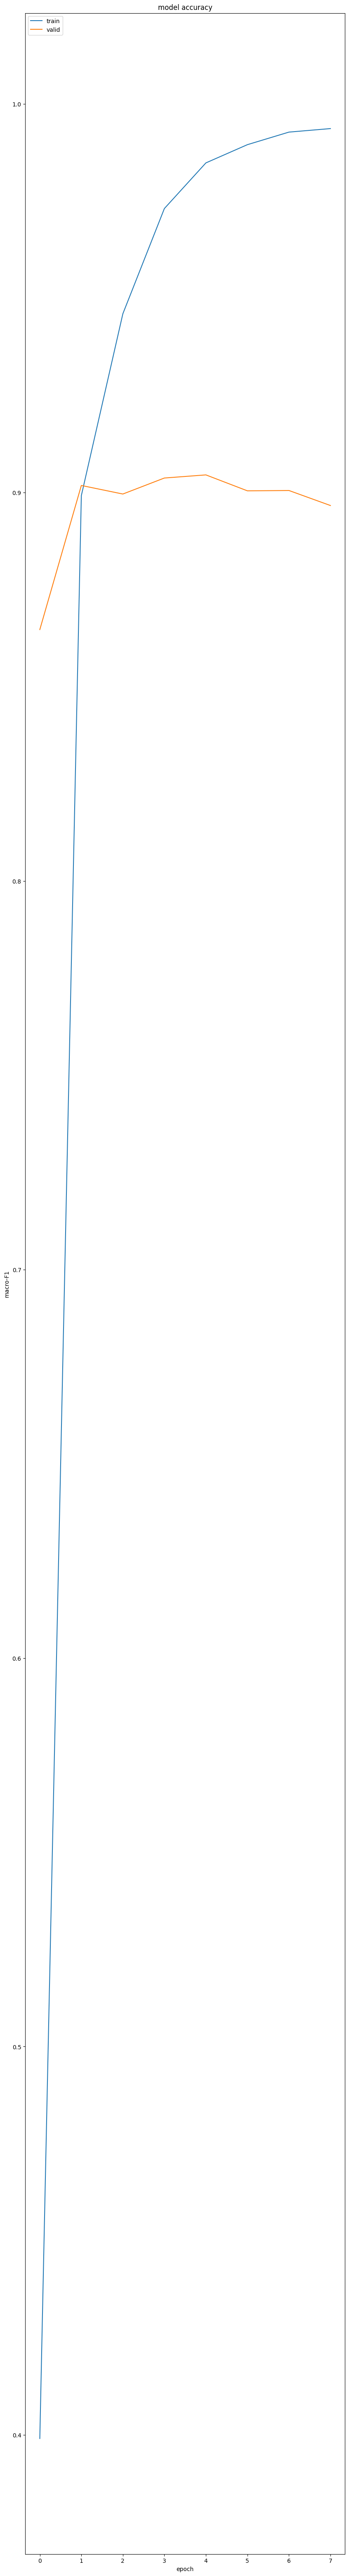

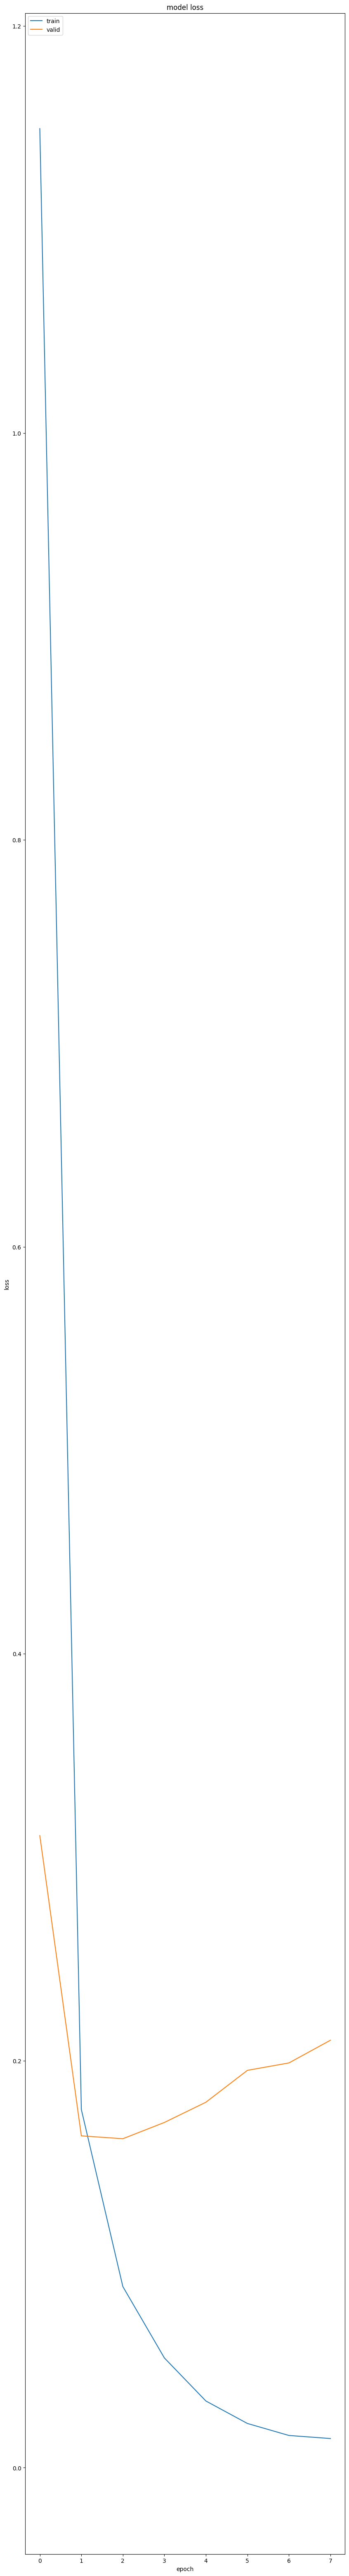

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 2s 24ms/step - loss: 0.1703 - f1_score: 0.8762


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

63/63 [==============================] - 2s 28ms/step
              precision    recall  f1-score   support

       anger       0.91      0.93      0.92       275
        fear       0.92      0.86      0.89       224
         joy       0.93      0.94      0.94       695
        love       0.80      0.79      0.79       159
     sadness       0.97      0.95      0.96       581
    surprise       0.71      0.80      0.75        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_CNN'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_CNN']]

# Mostrar los ejemplos erróneos
errores[['tweet', 'emotion', 'prediction_CNN']]

63/63 [==============================] - 2s 30ms/step


,tweet,emotion,prediction_CNN
353,i could feel his breath on me and smell the sw...,joy,love
1664,im afraid to call the guy from yesterday becau...,sadness,anger
254,i feel blessed beyond blessed to share my life...,love,joy
212,i did finally get it if you didn t laugh left ...,joy,sadness
111,i feel is he generous,love,joy
...,...,...,...
1154,i feel that passionate about,joy,love
1899,ive got a off sale the ad says starting tomorr...,love,joy
1123,i feel like the writer wants me to think so an...,love,anger
466,i feel his hand on me to stay faithful,love,joy


### CNN con dos capas

Este modelo implementa una red neuronal convolucional (CNN) con dos capas de filtro de tamaño 5 y 3, respectivamente, que se aplican sobre la entrada de datos, que es una secuencia de vectores de embedding de palabras. Después de aplicar estos filtros, se aplica una capa de pooling global, que toma el máximo valor de cada filtro y lo reduce a un vector unidimensional. Luego, hay dos capas densas, una con 64 unidades y la otra con el número de clases en el dataset (7 en este caso). La primera capa densa tiene una función de activación ReLU y la segunda tiene una función de activación softmax. Además, hay una capa de dropout con tasa de 0.5 para prevenir overfitting. Finalmente, se compila el modelo con la función de pérdida categorical crossentropy y la métrica F1 con una media macro.

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=6, average='macro')])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 300)           4563000   
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 128)           192128    
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 64)            24640     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 43s 335ms/step - loss: 1.4543 - f1_score: 0.1769 - val_loss: 0.8888 - val_f1_score: 0.2819
Epoch 2/20
125/125 [==============================] - 41s 329ms/step - loss: 0.4655 - f1_score: 0.7134 - val_loss: 0.2198 - val_f1_score: 0.8885
Epoch 3/20
125/125 [==============================] - 42s 340ms/step - loss: 0.1778 - f1_score: 0.9061 - val_loss: 0.1991 - val_f1_score: 0.8994
Epoch 4/20
125/125 [==============================] - 41s 327ms/step - loss: 0.1178 - f1_score: 0.9351 - val_loss: 0.2208 - val_f1_score: 0.8983
Epoch 5/20
125/125 [==============================] - 41s 329ms/step - loss: 0.0831 - f1_score: 0.9555 - val_loss: 0.2627 - val_f1_score: 0.8980
Epoch 6/20
125/125 [==============================] - 42s 338ms/step - loss: 0.0622 - f1_score: 0.9659 - val_loss: 0.2859 - val_f1_score: 0.8946
Epoch 7/20
125/125 [==============================] - 40s 321ms/step - loss: 0.0475 - f1_score: 0.9753 - val_loss: 0.2951 - val_f1

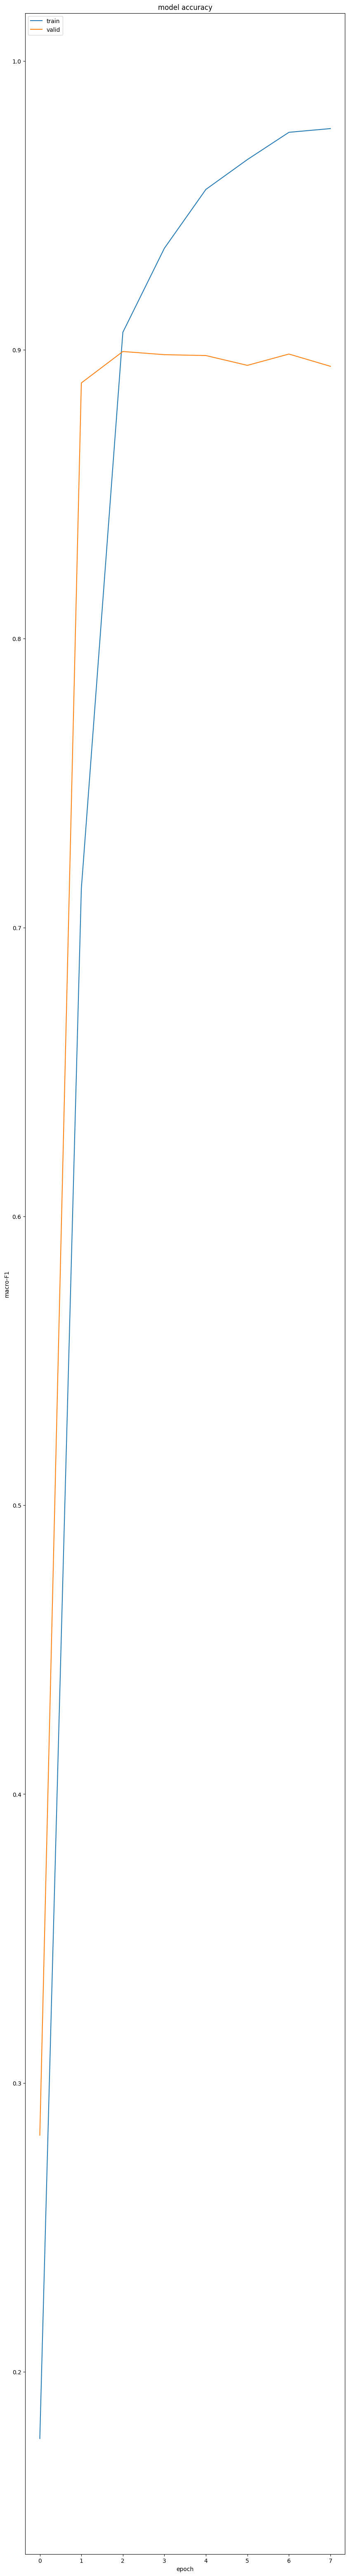

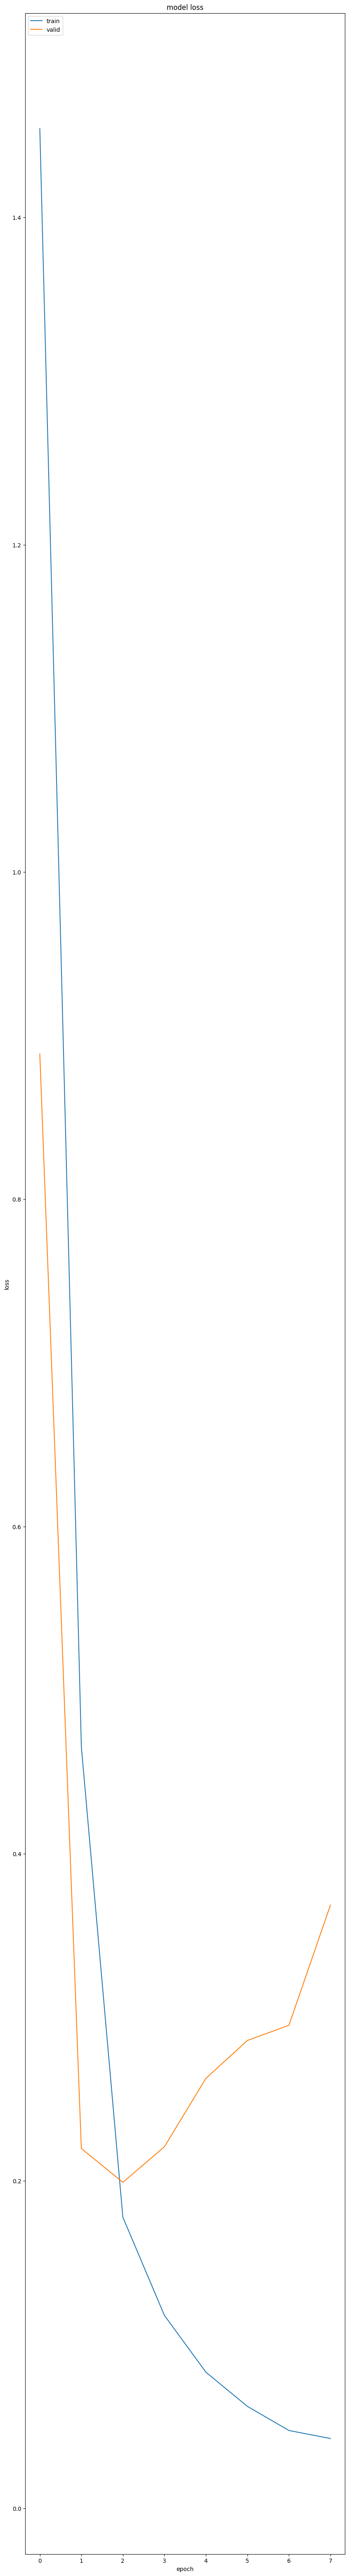

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 1s 19ms/step - loss: 0.1956 - f1_score: 0.8663


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

       anger       0.91      0.90      0.91       275
        fear       0.91      0.87      0.89       224
         joy       0.93      0.94      0.93       695
        love       0.77      0.84      0.80       159
     sadness       0.96      0.94      0.95       581
    surprise       0.69      0.74      0.72        66

    accuracy                           0.91      2000
   macro avg       0.86      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_CNN_2L'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_CNN_2L']]

# Mostrar los ejemplos erróneos
errores[['tweet', 'emotion', 'prediction_CNN_2L']]

63/63 [==============================] - 2s 32ms/step


,tweet,emotion,prediction_CNN_2L
353,i could feel his breath on me and smell the sw...,joy,love
1289,at a party i met a girl who drew me to her,anger,surprise
1664,im afraid to call the guy from yesterday becau...,sadness,anger
254,i feel blessed beyond blessed to share my life...,love,joy
251,i hope everyone can help with charity work wit...,sadness,anger
...,...,...,...
20,im not sure the feeling of loss will ever go a...,sadness,love
1842,i feel so amazing musicjuzz,joy,surprise
1154,i feel that passionate about,joy,love
1123,i feel like the writer wants me to think so an...,love,anger


## Guardar los datos

In [ ]:
# Seleccionar las columnas en el orden deseado
errors = df_test[['tweet', 'emotion', 'prediction_LSTM', 'prediction_LSTM_Dropout', 'prediction_CNN','prediction_CNN_2L']]
# Mostrar el DataFrame completo con las columnas originales y la predicción
errors

,tweet,emotion,prediction_LSTM,prediction_LSTM_Dropout,prediction_CNN,prediction_CNN_2L
1860,i feel so dirty but after spending a day at th...,sadness,love,sadness,sadness,sadness
353,i could feel his breath on me and smell the sw...,joy,love,love,love,love
1333,i just want to feel loved by you,love,love,love,love,love
905,i have felt the need to write out my sometimes...,anger,surprise,fear,anger,anger
1289,at a party i met a girl who drew me to her,anger,joy,anger,anger,surprise
...,...,...,...,...,...,...
1130,i help my daughter when she is feeling angry,anger,anger,anger,anger,anger
1294,i continue to write this i feel more and more ...,fear,fear,fear,fear,fear
860,i felt so bad for the bad grade and feeling li...,sadness,joy,sadness,sadness,sadness
1459,i never feel like anythings getting resolved w...,joy,joy,joy,joy,joy


In [ ]:
# Guardar el DataFrame de emociones mal predichas en un archivo CSV si es necesario
errors.to_csv('/content/drive/MyDrive/CARER/carer_misclassified_emotions_DL.csv', index=False)

# DEEP LEARNING CON TRANSFORMADORES

## Experimento con CARER

In [ ]:
!pip install accelerate==0.21.0
!pip install transformers[torch]==4.30.0
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import numpy as np
import torch
#Seeding for deterministic results i.e. showing same output
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

In [ ]:
#Cargamos los datasets
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
carer_train = '/content/drive/MyDrive/CARER/train.csv'
carer_validation = '/content/drive/MyDrive/CARER/valid.csv'
carer_test = '/content/drive/MyDrive/CARER/test.csv'

# Cargar los conjuntos de datos divididos en DataFrames de Pandas
df_train = pd.read_csv(carer_train, delimiter=",")
df_validation = pd.read_csv(carer_validation, delimiter=",")
df_test = pd.read_csv(carer_test, delimiter=",")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_validation.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet', 'emotion'],
        num_rows: 16000
    })
    valid: Dataset({
        features: ['tweet', 'emotion'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tweet', 'emotion'],
        num_rows: 2000
    })
})

In [ ]:
dataset['test'][0]

{'tweet': 'im feeling rather rotten so im not very ambitious right now',
 'emotion': 'sadness'}

In [ ]:
dataset = dataset.class_encode_column("emotion")
labels = dataset['train'].features['emotion']
print(labels.names)

Casting to class labels:   0%|          | 0/16000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2000 [00:00<?, ? examples/s]

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'distilbert/distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

# Tokenize the text and prepare input features
def tokenize_function(examples):
    return tokenizer(examples['tweet'], padding=True, truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("emotion", "labels")
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from transformers import Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=len(labels.names)).to(device)

batch_size = 16
model_name = "finetuned_extended_model_negative_attitudinal_function_identification_distilBERT"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["valid"],
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bia

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.272400,0.239042,0.906600,0.910958,0.908195
2,0.153600,0.172219,0.930655,0.894278,0.910376
3,0.105800,0.173067,0.916598,0.920558,0.916976
4,0.075200,0.225896,0.919067,0.905579,0.911483
5,0.041900,0.260936,0.909581,0.911383,0.910410


TrainOutput(global_step=5000, training_loss=0.19575286102294923, metrics={'train_runtime': 652.0669, 'train_samples_per_second': 122.687, 'train_steps_per_second': 7.668, 'total_flos': 1724372473953600.0, 'train_loss': 0.19575286102294923, 'epoch': 5.0})

### Guadar el modelo pre-entrenado para poder manipular los datos

In [ ]:
# Guardar el modelo y el tokenizador en Google Drive
model.save_pretrained('/content/drive/MyDrive/CARER/carer_finetuned')
tokenizer.save_pretrained('/content/drive/MyDrive/CARER/carer_finetuned')

('/content/drive/MyDrive/CARER/carer_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/CARER/carer_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/CARER/carer_finetuned/vocab.txt',
 '/content/drive/MyDrive/CARER/carer_finetuned/added_tokens.json',
 '/content/drive/MyDrive/CARER/carer_finetuned/tokenizer.json')

### **Cargar el modelo pre-entrenado para poder visualizar datos**

In [ ]:
# Cargar el modelo y el tokenizador guardados
model_path = '/content/drive/MyDrive/CARER/carer_finetuned'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=len(labels.names)).to(device)

### Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
preds_output = trainer.predict(tokenized_dataset['test'])
print(preds_output.metrics)

{'test_loss': 0.17951473593711853, 'test_precision': 0.8821161274059417, 'test_recall': 0.8888776267006401, 'test_f1': 0.8795255926448909, 'test_runtime': 4.1471, 'test_samples_per_second': 482.266, 'test_steps_per_second': 30.142}


In [ ]:
from sklearn.metrics import classification_report

y_true = np.array(tokenized_dataset['test']["labels"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       anger       0.91      0.93      0.92       275
        fear       0.89      0.88      0.88       224
         joy       0.93      0.97      0.95       695
        love       0.92      0.70      0.79       159
     sadness       0.99      0.95      0.97       581
    surprise       0.66      0.91      0.76        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.92      0.92      2000



In [ ]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open('/content/drive/MyDrive/CARER/classification_report_extended_model_finetuning.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

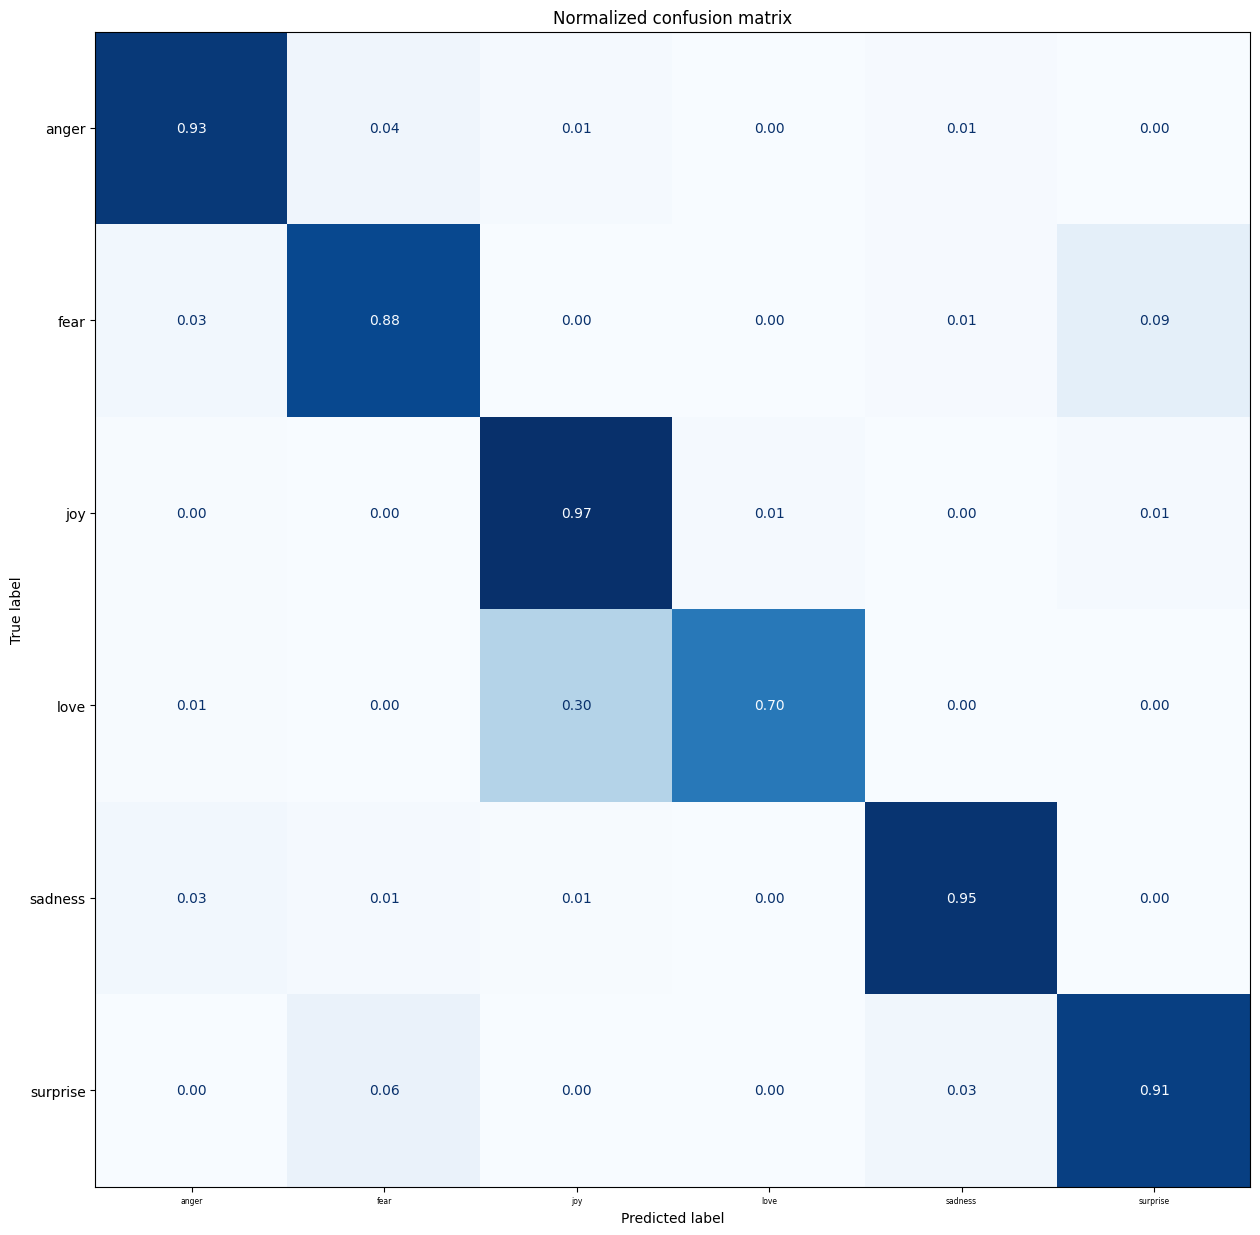

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(20, 15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    ax.tick_params(axis='x', which='major', labelsize=5.5)  # Adjust to fit
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_pred, y_true, labels.names)

In [ ]:
from torch.nn.functional import cross_entropy
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegurarse de que el tokenizador esté correctamente configurado
transformer_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)
data_collator = DataCollatorWithPadding(tokenizer)

# Definir la función de forward pass con etiquetas
def forward_pass_with_label(batch):
    # Asegurarse de que los inputs estén correctamente formateados y en el dispositivo adecuado
    inputs = tokenizer(batch['tweet'], padding=True, truncation=True, return_tensors="pt").to(device)
    labels = torch.tensor(batch["labels"]).to(device)
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, labels, reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

# Formatear el dataset a formato python para mapear la función
tokenized_dataset.set_format("python", columns=["tweet", "labels"])

# Aplicar la función forward_pass_with_label al dataset de prueba
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_label, batched=True, batch_size=16)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(row):
    return tokenized_dataset["train"].features["labels"].int2str(row)

In [ ]:
tokenized_dataset.set_format("pandas")
cols = ["tweet", "labels", "predicted_label", "loss"]
df = tokenized_dataset["test"][:][cols]
df["labels"] = df["labels"].apply(label_int2str)
df["predicted_label"] = (df["predicted_label"]
                              .apply(label_int2str))

In [ ]:
loss_values = df.sort_values("loss", ascending=False).head(50)
loss_values

,tweet,labels,predicted_label,loss
816,whenever i put myself in others shoes and try ...,anger,joy,10.489623
1928,i feel inside cause life is like a game someti...,fear,sadness,8.885627
150,im feeling rather angsty and listless,sadness,joy,8.438934
1627,i feel i can only hope im not alone in these t...,sadness,joy,8.247410
767,i feel like most teams would have appeased jac...,anger,joy,8.041621
476,i feel quite helpless in all of this so prayer...,sadness,fear,7.184805
193,i really dont like quinn because i feel like s...,anger,sadness,6.923147
1037,i always feel so helpless during times of disa...,sadness,fear,6.828723
426,i feel unprotected a class post count link hre...,sadness,fear,6.787735
591,i feel inside this life is like a game sometim...,sadness,surprise,6.735993


In [ ]:
loss_values.to_csv('/content/drive/MyDrive/CARER/loss_values_extended_model_finetuning.tsv',header =True, sep = '\t',index=False)
df.to_csv('/content/drive/MyDrive/CARER/preds_extended_model_finetuning.tsv',header =True, sep = '\t',index=False)